Vehicle velocity model with slope: closed loop model with PI-controller; iterative simulation approach.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [3]:
import numpy as np
from scipy.integrate import odeint
from matplotlib import pyplot as plt
from scipy import constants

In [4]:
def eval_model(model, xs):
    return np.array(list(map(model, xs)))

## Mathematical model

Model of a closed loop system with PI-controller

$\frac{dv(t)}{dt} = \frac{1}{m} [ F_p K_c (v_{SP}(t) - v(t)) + \frac{K_c}{\tau_i} \int e(t) dt - \frac{1}{2} \rho A C_d v(t)^2 ] - g sin(\theta(t))$

In [5]:
# Mass (car + load), kg
m = 700

# Thrust parameter, (N / %pedal)
F_p = 30

# Air density, kg/m^3
rho = 1.225 

# vehicle cross-sectional area (m^2)
A = 5

# Drag coefficient
C_d = 0.24

# Controller gain and integration constant
K_c = 20.
tau_i = 12.

def vehicle_model(v, t, setpoint_func, disturbance_func, accumulated_error):
    
    v_sp = setpoint_func(t)
    theta = disturbance_func(t)
        
    drive = F_p * K_c * (v_sp - v) + (K_c / tau_i) * accumulated_error
    drag = 0.5 * rho * A * C_d * (v**2)
    slope = constants.g * np.sin(theta)
    
    return (1. / m) * (drive - drag) - slope
    

## Simulation

In [6]:
t = np.linspace(0, 200, 100)

In [7]:
# setpoint function
def setpoint_strategy(t):
    
    if t < 25:
        return 0
    
    if t >= 25 and t < 100:
        return 10
    
    if t >= 100 and t < 150:
        return 15
    
    if t >= 150:
        return 10
    
# disturbance function   
def no_slope(t):
    return 0

Iterative simulation

In [8]:
initial = 0.
v_sim = [initial, ]
accumulated_error = 0.

for i in range(len(t) - 1):
    
    # take t[i] and t[i+1]
    t_pair = t[i:i+2] 
    t_now, t_next = t_pair
    
    step_sim = odeint(vehicle_model, initial, t_pair, args=(setpoint_strategy, no_slope, accumulated_error))

    # take the last value
    v_last = step_sim.reshape(-1)[-1]
    
    # appendt it to the resulting list
    v_sim.append(v_last)
    
    # save it as initial condition for the next run
    initial = v_last 
    
    # compute and accumulate error
    error = setpoint_strategy(t_next) - v_last
    error_area_increment = error * (t_next - t_now)
    accumulated_error += error_area_increment
    
v_sim = np.array(v_sim).reshape(-1)

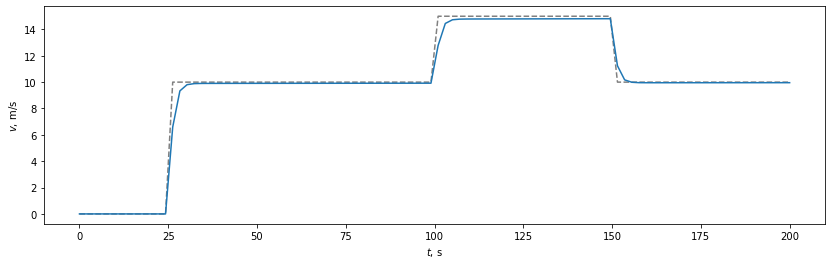

In [9]:
plt.figure(figsize=(14, 4))
plt.plot(t, eval_model(setpoint_strategy, t), '--', color='gray')
plt.plot(t, v_sim)

plt.xlabel('$t$, s')
plt.ylabel('$v$, m/s')
plt.show()

In [10]:
v_sim

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  6.59315548,  9.33614485,
        9.80650361,  9.88726499,  9.90148584,  9.9043478 ,  9.90526863,
        9.90585585,  9.90638376,  9.90689911,  9.90741008,  9.90791797,
        9.90842304,  9.90892533,  9.90942486,  9.90992165,  9.91041571,
        9.91090707,  9.91139573,  9.9118817 ,  9.91236502,  9.91284568,
        9.9133237 ,  9.9137991 ,  9.91427189,  9.91474209,  9.91520971,
        9.91567477,  9.91613727,  9.91659724,  9.91705468,  9.91750962,
        9.91796205,  9.91841201,  9.9188595 ,  9.91930453,  9.91974712,
       12.78781747, 14.45270963, 14.73258822, 14.78033982, 14.78927028,
       14.79170631, 14.79305177, 14.79420985, 14.79533153, 14.79644211,
       14.79754581, 14.79864339, 14.79973499, 14.80082067, 14.80190046,
       14.80297439, 14.8040425 , 14.80510481, 14.80616136, 14.80

In [11]:
error = eval_model(setpoint_strategy, t) - v_sim

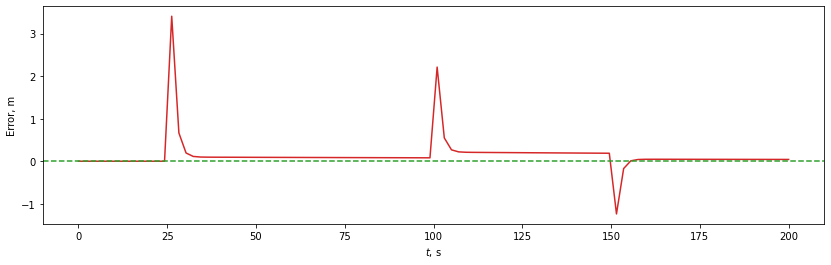

In [12]:
plt.figure(figsize=(14, 4))
plt.plot(t, error, color='tab:red')
plt.axhline(0, linestyle='--', color='tab:green')
plt.xlabel('$t$, s')
plt.ylabel('Error, m')
plt.show()

In [13]:
sse = np.sum(np.square(error))

print('Sum of squared errors during simulation: {:.3f}'.format(sse))

Sum of squared errors during simulation: 20.098
